In [8]:
import os

# Set model cache directory (must be set before importing torch)
MODELS_DIR = '../models'
os.makedirs(MODELS_DIR, exist_ok=True)
os.environ['TORCH_HOME'] = MODELS_DIR

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms, models
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Model cache directory: {os.path.abspath(MODELS_DIR)}")


Using device: cuda
Model cache directory: D:\Python_projects\UnderstandingDL\models


In [9]:
# Configuration
DATA_DIR = '../data/ClassifyLeaves'
BATCH_SIZE = 64
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4
VAL_RATIO = 0.2  # 20% for validation
NUM_WORKERS = 0  # Set to 0 for Windows compatibility, can increase on Linux
MODEL_SAVE_PATH = os.path.join(MODELS_DIR, 'kcf-resnet18.pth')

# Image size for ResNet
IMG_SIZE = 224


In [10]:
# Load train.csv and create label mapping
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

# Create label to index mapping
labels = sorted(train_df['label'].unique())
label2idx = {label: idx for idx, label in enumerate(labels)}
idx2label = {idx: label for label, idx in label2idx.items()}
num_classes = len(labels)

print(f"Number of classes: {num_classes}")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")


Number of classes: 176
Training samples: 18353
Test samples: 8800


In [11]:
# Define Dataset class
class LeavesDataset(Dataset):
    def __init__(self, df, data_dir, label2idx=None, transform=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.label2idx = label2idx
        self.transform = transform
        self.is_test = is_test
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.df.loc[idx, 'image'])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image
        else:
            label = self.df.loc[idx, 'label']
            label_idx = self.label2idx[label]
            return image, label_idx


In [12]:
# Define data augmentation and transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [13]:
# Split train data into train and validation sets
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(
    train_df, 
    test_size=VAL_RATIO, 
    random_state=42, 
    stratify=train_df['label']
)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")

# Create datasets
train_dataset = LeavesDataset(train_data, DATA_DIR, label2idx, transform=train_transform)
val_dataset = LeavesDataset(val_data, DATA_DIR, label2idx, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")


Training set size: 14682
Validation set size: 3671
Number of training batches: 230
Number of validation batches: 58


In [15]:
# Define model - ResNet18 with pretrained weights
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Modify the last fully connected layer for our number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

print(f"Model: ResNet18")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to ../models\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 26.3MB/s]


Model: ResNet18
Number of parameters: 11,266,800


In [16]:
# Training function
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation', leave=False)
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [17]:
# Training loop
history = {
    'train_loss': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_epoch = 0

print("Starting training...")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch results
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}% | "
          f"LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'label2idx': label2idx,
            'idx2label': idx2label
        }, MODEL_SAVE_PATH)
        print(f"  -> Best model saved! (Val Acc: {val_acc:.2f}%)")

print("=" * 60)
print(f"Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}")


Starting training...


Epoch [1/30] Train Loss: 3.4973 | Val Loss: 2.1959 | Val Acc: 47.51% | LR: 0.000100
  -> Best model saved! (Val Acc: 47.51%)


Epoch [2/30] Train Loss: 1.7841 | Val Loss: 1.3908 | Val Acc: 63.50% | LR: 0.000099
  -> Best model saved! (Val Acc: 63.50%)


Epoch [3/30] Train Loss: 1.1698 | Val Loss: 0.8722 | Val Acc: 77.61% | LR: 0.000098
  -> Best model saved! (Val Acc: 77.61%)


Epoch [4/30] Train Loss: 0.8388 | Val Loss: 0.7955 | Val Acc: 77.88% | LR: 0.000096
  -> Best model saved! (Val Acc: 77.88%)


Epoch [5/30] Train Loss: 0.6456 | Val Loss: 0.5978 | Val Acc: 83.22% | LR: 0.000093
  -> Best model saved! (Val Acc: 83.22%)


Epoch [6/30] Train Loss: 0.5281 | Val Loss: 0.5391 | Val Acc: 84.17% | LR: 0.000090
  -> Best model saved! (Val Acc: 84.17%)


Epoch [7/30] Train Loss: 0.4329 | Val Loss: 0.4103 | Val Acc: 87.82% | LR: 0.000087
  -> Best model saved! (Val Acc: 87.82%)


Epoch [8/30] Train Loss: 0.3729 | Val Loss: 0.3666 | Val Acc: 89.59% | LR: 0.000083
  -> Best model saved! (Val Acc: 89.59%)


Epoch [9/30] Train Loss: 0.3186 | Val Loss: 0.3510 | Val Acc: 89.02% | LR: 0.000079


Epoch [10/30] Train Loss: 0.2777 | Val Loss: 0.3003 | Val Acc: 90.36% | LR: 0.000075
  -> Best model saved! (Val Acc: 90.36%)


Epoch [11/30] Train Loss: 0.2381 | Val Loss: 0.2989 | Val Acc: 90.38% | LR: 0.000070
  -> Best model saved! (Val Acc: 90.38%)


Epoch [12/30] Train Loss: 0.2166 | Val Loss: 0.2609 | Val Acc: 91.88% | LR: 0.000065
  -> Best model saved! (Val Acc: 91.88%)


Epoch [13/30] Train Loss: 0.1971 | Val Loss: 0.2452 | Val Acc: 91.99% | LR: 0.000060
  -> Best model saved! (Val Acc: 91.99%)


Epoch [14/30] Train Loss: 0.1771 | Val Loss: 0.2304 | Val Acc: 92.15% | LR: 0.000055
  -> Best model saved! (Val Acc: 92.15%)


Epoch [15/30] Train Loss: 0.1577 | Val Loss: 0.2288 | Val Acc: 92.15% | LR: 0.000050


Epoch [16/30] Train Loss: 0.1431 | Val Loss: 0.2036 | Val Acc: 93.11% | LR: 0.000045
  -> Best model saved! (Val Acc: 93.11%)


Epoch [17/30] Train Loss: 0.1269 | Val Loss: 0.2068 | Val Acc: 93.46% | LR: 0.000040
  -> Best model saved! (Val Acc: 93.46%)


Epoch [18/30] Train Loss: 0.1224 | Val Loss: 0.1883 | Val Acc: 93.63% | LR: 0.000035
  -> Best model saved! (Val Acc: 93.63%)


Epoch [19/30] Train Loss: 0.1108 | Val Loss: 0.1716 | Val Acc: 93.93% | LR: 0.000030
  -> Best model saved! (Val Acc: 93.93%)


Epoch [20/30] Train Loss: 0.0983 | Val Loss: 0.1777 | Val Acc: 94.01% | LR: 0.000025
  -> Best model saved! (Val Acc: 94.01%)


Epoch [21/30] Train Loss: 0.0967 | Val Loss: 0.1722 | Val Acc: 94.20% | LR: 0.000021
  -> Best model saved! (Val Acc: 94.20%)


Epoch [22/30] Train Loss: 0.0891 | Val Loss: 0.1553 | Val Acc: 95.21% | LR: 0.000017
  -> Best model saved! (Val Acc: 95.21%)


Epoch [23/30] Train Loss: 0.0851 | Val Loss: 0.1525 | Val Acc: 94.91% | LR: 0.000013


Epoch [24/30] Train Loss: 0.0788 | Val Loss: 0.1463 | Val Acc: 95.04% | LR: 0.000010


Epoch [25/30] Train Loss: 0.0754 | Val Loss: 0.1455 | Val Acc: 95.21% | LR: 0.000007


Epoch [26/30] Train Loss: 0.0709 | Val Loss: 0.1497 | Val Acc: 95.29% | LR: 0.000004
  -> Best model saved! (Val Acc: 95.29%)


Epoch [27/30] Train Loss: 0.0687 | Val Loss: 0.1453 | Val Acc: 95.29% | LR: 0.000002


Epoch [28/30] Train Loss: 0.0699 | Val Loss: 0.1440 | Val Acc: 95.45% | LR: 0.000001
  -> Best model saved! (Val Acc: 95.45%)


Epoch [29/30] Train Loss: 0.0680 | Val Loss: 0.1460 | Val Acc: 95.42% | LR: 0.000000


Epoch [30/30] Train Loss: 0.0676 | Val Loss: 0.1462 | Val Acc: 95.40% | LR: 0.000000
Training completed!
Best validation accuracy: 95.45% at epoch 28


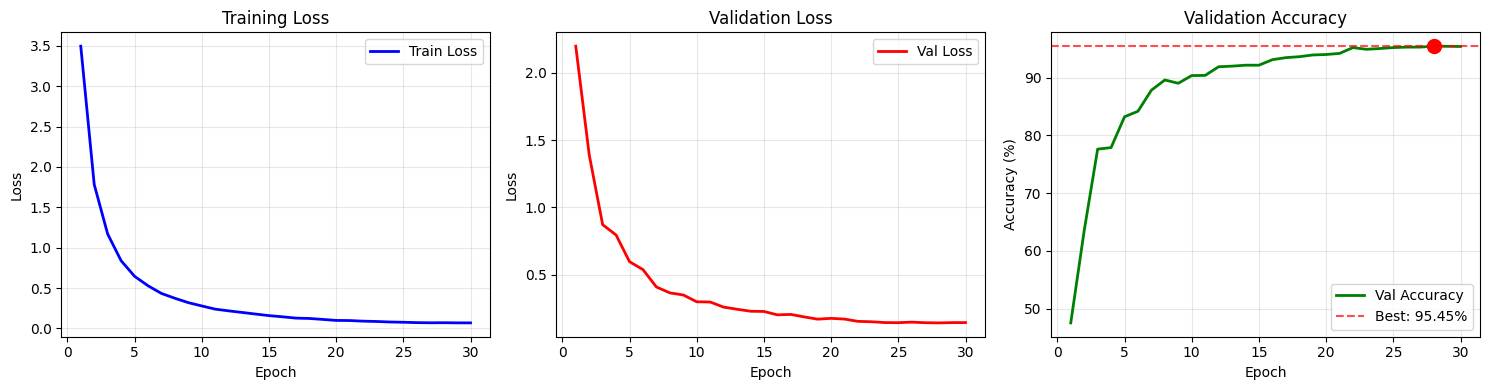


Training history saved to 'training_history.png'


In [18]:
# Visualize training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

epochs_range = range(1, NUM_EPOCHS + 1)

# Plot training loss
axes[0].plot(epochs_range, history['train_loss'], 'b-', linewidth=2, label='Train Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot validation loss
axes[1].plot(epochs_range, history['val_loss'], 'r-', linewidth=2, label='Val Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Validation Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot validation accuracy
axes[2].plot(epochs_range, history['val_acc'], 'g-', linewidth=2, label='Val Accuracy')
axes[2].axhline(y=best_val_acc, color='r', linestyle='--', alpha=0.7, label=f'Best: {best_val_acc:.2f}%')
axes[2].scatter([best_epoch], [best_val_acc], color='r', s=100, zorder=5)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy (%)')
axes[2].set_title('Validation Accuracy')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTraining history saved to 'training_history.png'")


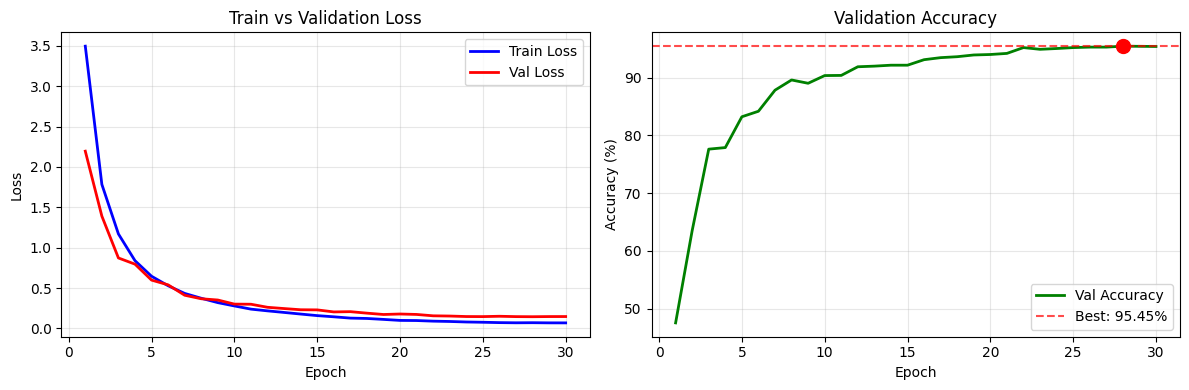


Training Summary
Best Epoch: 28
Best Validation Accuracy: 95.45%
Final Train Loss: 0.0676
Final Val Loss: 0.1462
Model saved to: ../models\kcf-resnet18.pth


In [19]:
# Combined loss plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss comparison
axes[0].plot(epochs_range, history['train_loss'], 'b-', linewidth=2, label='Train Loss')
axes[0].plot(epochs_range, history['val_loss'], 'r-', linewidth=2, label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train vs Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation accuracy
axes[1].plot(epochs_range, history['val_acc'], 'g-', linewidth=2, label='Val Accuracy')
axes[1].axhline(y=best_val_acc, color='r', linestyle='--', alpha=0.7, label=f'Best: {best_val_acc:.2f}%')
axes[1].scatter([best_epoch], [best_val_acc], color='r', s=100, zorder=5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_summary.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final summary
print("\n" + "=" * 60)
print("Training Summary")
print("=" * 60)
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")
print(f"Model saved to: {MODEL_SAVE_PATH}")


In [20]:
# Load best model for prediction
checkpoint = torch.load(MODEL_SAVE_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
idx2label = checkpoint['idx2label']
print(f"Loaded best model from: {MODEL_SAVE_PATH}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")

# Create test dataset and dataloader
test_dataset = LeavesDataset(test_df, DATA_DIR, transform=val_transform, is_test=True)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Test samples: {len(test_dataset)}")
print(f"Test batches: {len(test_loader)}")


Loaded best model from: ../models\kcf-resnet18.pth
Best validation accuracy: 95.45%
Test samples: 8800
Test batches: 138


In [21]:
# Predict on test set
model.eval()
predictions = []

with torch.no_grad():
    pbar = tqdm(test_loader, desc='Predicting')
    for images in pbar:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        predictions.extend(predicted.cpu().numpy())

# Convert indices to labels
predicted_labels = [idx2label[idx] for idx in predictions]

print(f"Total predictions: {len(predicted_labels)}")


Predicting: 100%|██████████| 138/138 [00:17<00:00,  7.80it/s]

Total predictions: 8800


In [22]:
# Create submission dataframe
submission_df = pd.DataFrame({
    'image': test_df['image'],
    'label': predicted_labels
})

# Save to submission file
submission_path = os.path.join(DATA_DIR, 'sample_submission.csv')
submission_df.to_csv(submission_path, index=False)

print(f"Submission saved to: {submission_path}")
print(f"\nSubmission preview:")
print(submission_df.head(10))
print(f"\nLabel distribution (top 10):")
print(submission_df['label'].value_counts().head(10))


Submission saved to: ../data/ClassifyLeaves\sample_submission.csv

Submission preview:
              image                         label
0  images/18353.jpg               asimina_triloba
1  images/18354.jpg                  betula_nigra
2  images/18355.jpg           platanus_acerifolia
3  images/18356.jpg                pinus_bungeana
4  images/18357.jpg           platanus_acerifolia
5  images/18358.jpg       koelreuteria_paniculata
6  images/18359.jpg             magnolia_stellata
7  images/18360.jpg  metasequoia_glyptostroboides
8  images/18361.jpg                 tilia_cordata
9  images/18362.jpg               ulmus_americana

Label distribution (top 10):
label
prunus_virginiana    75
cedrus_libani        73
prunus_sargentii     69
pinus_bungeana       61
pinus_nigra          60
cornus_mas           58
magnolia_stellata    58
pinus_thunbergii     57
nyssa_sylvatica      57
pinus_parviflora     57
Name: count, dtype: int64
